In [1]:
using Plots
using NearestNeighbors
using DataStructures
using DelimitedFiles

## Disjoint-Sets

In order to find connected vertices in undirected
graph, we use the *Disjoint
sets* from DataStructures.jl.

In [2]:
a = IntDisjointSets(7)  # creates a forest comprised of 7 singletons

IntDisjointSets{Int64}([1, 2, 3, 4, 5, 6, 7], [0, 0, 0, 0, 0, 0, 0], 7)

In [3]:
union!(a, 1, 2)          # merges the sets that contain 1 and 2 into one and returns the root of the new set
union!(a, 3, 5)          # merges the sets that contain 3 and 5 into one and returns the root of the new set
a

IntDisjointSets{Int64}([1, 1, 3, 4, 3, 6, 7], [1, 0, 1, 0, 0, 0, 0], 5)

In [4]:
find_root!(a, 3)         # finds the root element of the subset that contains 3

3

In [5]:
x, y = 3, 5
in_same_set(a, x, y)     # determines whether x and y are in the same set

true

In [6]:
num_groups(a)            # returns the number of sets

5

## Read data

In [7]:
toy = readdlm(joinpath("..", "ToMATo", "inputs", "toy_example_w_density.txt"))
points = collect(toy')

3×10000 Matrix{Float64}:
    0.392345     5.40588     0.215228  …     2.99077     1.11412     5.19651
    1.24778      2.40142     1.26093         7.13162     8.71054     7.12939
 1875.0       4250.0      1525.0          3450.0      1825.0      3525.0

gaussian_nn (generic function with 1 method)

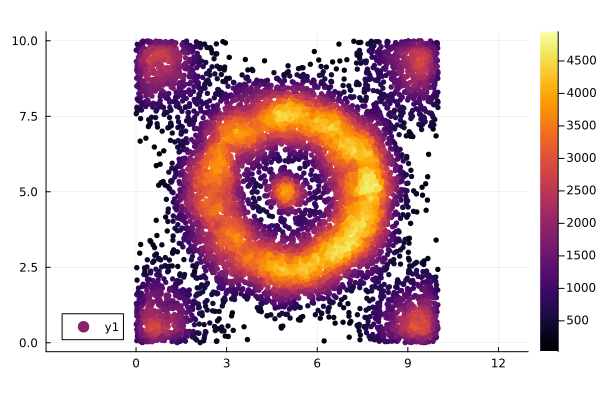

In [13]:
scatter( points[1,:], points[2,:], aspect_ratio = 1, 
         ms = 3, marker_z = points[3,:], palette = :jet, markerstrokewidth=0)

In [10]:
function data2clust(points, radius, τ)
    
    balltree = BallTree(points[1:2,:])
    idxs = inrange(balltree, points[1:2,:], radius, true)
    f = points[3,:]
    intervals = Dict{Int,Tuple{Float64,Float64}}()
    v = sortperm(f, rev = true) # sort vertices using f
    f .= f[v] # sort f
    vertices_corr_inv = Dict(zip(v, 1:n)) #indexes of vertices in f
    G = [[vertices_corr_inv[i] for i in subset] for subset in idxs[v]]
    𝒰 = IntDisjointSets(n)
    for i = eachindex(v)
        𝒩 = [j for j in G[i] if j < i]
        if length(𝒩) == 0
            intervals[i] = (f[i], Inf)
        else
            g = 𝒩[argmax(view(f, 𝒩))] # approximate gradient at vertex i
            eᵢ = find_root!(𝒰, g) # r(eᵢ)
            union!(𝒰, eᵢ, i) # Attach vertex i to the entry eᵢ
            for j in 𝒩
                e = find_root!(𝒰, j) # r(e)
                if e != eᵢ && min(f[e], f[eᵢ]) <= f[i] + τ # merge
                    if f[e] < f[eᵢ]
                        union!(𝒰, eᵢ, e)
                        intervals[j] = (f[e], f[eᵢ])
                    else
                        union!(𝒰, e, eᵢ)
                        intervals[i] = (f[eᵢ], f[e])
                    end 
                    eᵢ = find_root!(𝒰, e)   
                end
            end
        end
    end
    # the collection of entries e of 𝒰 such that f(r(e)) ≥ τ
    s = Set{Int}([])
    for i = 1:n
        g = find_root!(𝒰, i) #  r(e)
        if f[g] >= τ 
           push!(s, g)
        end
    end
    labels = zeros(Int, n)
    for (c,j) in enumerate(s), i in 1:n
        if in_same_set(𝒰, j, i)
            labels[v[i]] = c
        end
    end

    return labels, intervals

end


data2clust (generic function with 1 method)

In [11]:
τ = Inf
radius = 0.25
labels, intervals = data2clust(points, radius, τ)
pd = [v for v in values(intervals) if isfinite(v[2])]

birth = getindex.(pd,1)
death = getindex.(pd,2)
scatter(birth, death)
bmin, bmax = extrema(getindex.(pd,1))
beps = 0.1 * (bmax-bmin) 
deps = 0.1 * (dmax-dmin)
xlims!(bmin-beps,bmax+beps)
ylims!(dmin-deps,dmax-deps)
plot!(x -> x)

LoadError: UndefVarError: `dmax` not defined

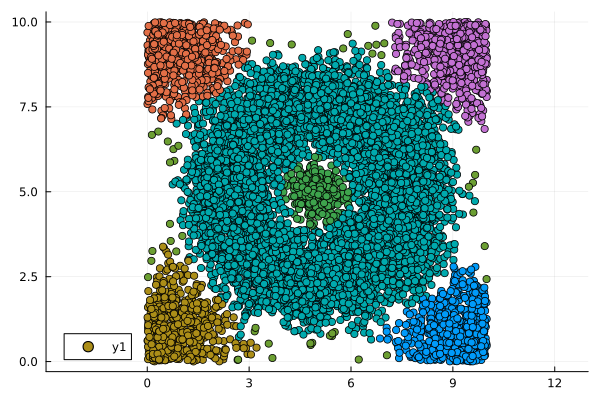

In [12]:
τ = 1000
labels, intervals = data2clust(points, radius, τ)
scatter( points[1,:], points[2,:], c = labels, aspect_ratio = 1)